In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
from pathlib import Path

ERROR 1: PROJ: proj_create_from_database: Open of /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/share/proj failed


In [11]:
date = '01012020'

day = date[0:2]
month = date[2:4]
year = date[4:8]
directory=Path(f'/g/data/rv74/satellite-products/arc/der/himawari-ahi/solar/p1s/v1.1/{year}/{month}/{day}')
files = sorted(str(p) for p in directory.rglob("*.nc"))
def _preprocess(ds):
    return ds.drop_vars(set(ds.data_vars) - {'surface_global_irradiance'})

himawari = xr.open_mfdataset(
    files,
    combine='by_coords',
    preprocess=_preprocess,
    engine='h5netcdf',
)

In [24]:
##### ERA5 Data
era5_dir = [
    Path(f"/g/data/rt52/era5/single-levels/reanalysis/msdwswrf/{year}"),
]
era5_file = [f for d in era5_dirs for f in d.glob(f"msdwswrf_era5_oper_sfc_{year}{month}*.nc")][0]
era5 = xr.open_dataset(era5_file)
# era5 = xr.open_mfdataset(
#     era5_files,
#     combine='by_coords',   # Use coordinate-based merging
#     data_vars='minimal',   # Avoid trying to align data_vars across files
#     coords='minimal',      # Avoid "coords='different'" error
#     compat='override',     # Avoid unnecessary compatibility checks
# )

In [13]:
era5 = era5.isel(time=slice(0,24))

In [14]:
lat_max = himawari.latitude.max().item()
lat_min = himawari.latitude.min().item()
lon_max = himawari.longitude.max().item()
lon_min = himawari.longitude.min().item()

era5_aus = era5.sel(
    latitude=slice(lat_max, lat_min),
    longitude=slice(lon_min, lon_max)
)

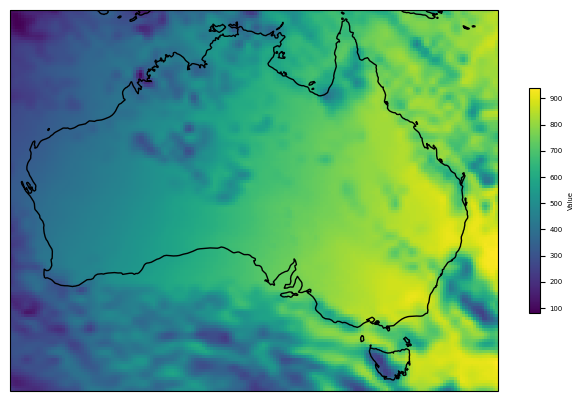

In [15]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

data=era5_aus.isel(time=0)

mesh=ax.pcolormesh(data.longitude.values, data.latitude.values, data.msdwswrf.values, cmap='viridis', transform=ccrs.PlateCarree())

ax.coastlines()
cbar = plt.colorbar(mesh,ax=ax,shrink=0.5)
cbar.ax.tick_params(labelsize=5)  # Set the font size for the colorbar ticks
cbar.set_label('Value', fontsize=5) 
 
plt.tight_layout()

plt.show()

In [16]:
himawari_clim = himawari.surface_global_irradiance.mean(dim='time')
era5_clim = era5_aus.msdwswrf.mean(dim='time')

era5_clim_interp = era5_clim.interp(
    latitude=himawari_clim.latitude,
    longitude=himawari_clim.longitude,
    method='linear'
)

In [17]:
era5_clim_interp = era5_clim_interp.load()
himawari_clim = himawari_clim.load()

In [18]:
diff = era5_clim_interp - himawari_clim

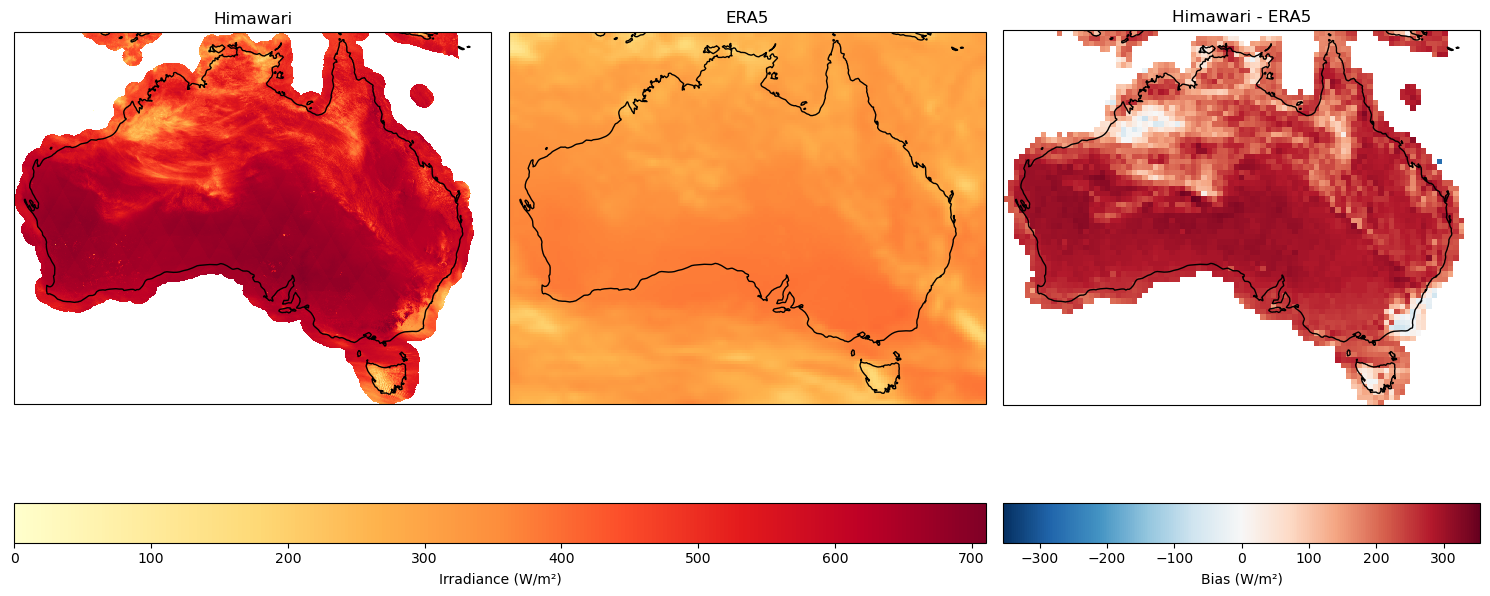

In [21]:
# Compute vmin/vmax as Python floats
vmin = min(himawari_clim.min().compute().item(), era5_clim.min().compute().item())
vmax = max(himawari_clim.max().compute().item(), era5_clim.max().compute().item())

# Create figure and use GridSpec to manage layout
fig = plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(2, 3, height_ratios=[20, 1])  # 2 rows, 3 columns; bottom row is for colorbars

# Create three map axes
projections = ccrs.PlateCarree()
ax1 = fig.add_subplot(gs[0, 0], projection=projections)
ax2 = fig.add_subplot(gs[0, 1], projection=projections)
ax3 = fig.add_subplot(gs[0, 2], projection=projections)

# Plot 1: Himawari
mesh1 = ax1.pcolormesh(
    himawari_clim.longitude, himawari_clim.latitude, himawari_clim,
    cmap='YlOrRd', vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), shading='auto'
)
ax1.set_title('Himawari')
ax1.coastlines()

# Plot 2: ERA5
mesh2 = ax2.pcolormesh(
    era5_clim.longitude, era5_clim.latitude, era5_clim,
    cmap='YlOrRd', vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), shading='auto'
)
ax2.set_title('ERA5')
ax2.coastlines()

# Plot 3: Difference
diff = himawari_clim - era5_clim
diff_vmax = abs(diff).max().compute().item()
mesh3 = ax3.pcolormesh(
    diff.longitude, diff.latitude, diff,
    cmap='RdBu_r', vmin=-diff_vmax, vmax=diff_vmax,
    transform=ccrs.PlateCarree(), shading='auto'
)
ax3.set_title('Himawari - ERA5')
ax3.coastlines()

# Colorbars
cax1 = fig.add_subplot(gs[1, 0:2])  # under first two plots
cax2 = fig.add_subplot(gs[1, 2])    # under third plot

cbar1 = fig.colorbar(mesh1, cax=cax1, orientation='horizontal')
cbar1.set_label('Irradiance (W/m²)')

cbar2 = fig.colorbar(mesh3, cax=cax2, orientation='horizontal')
cbar2.set_label('Bias (W/m²)')

# Final layout adjustment
plt.tight_layout()
plt.show()